In [1]:
from util import *
from glob import glob
import matplotlib.pyplot as plt
from shapely import wkt
pd.set_option("display.max_columns", None)

In [2]:
gdf = gpd.read_file(f"DSAS_TestData/transects_sample_intersects.geojson")
gdf["Date"] = pd.to_datetime(gdf.ShorelineID, dayfirst=True, format='mixed')
gdf["Year"] = gdf.Date.dt.year
gdf["YearsSinceBase"] = (gdf.Date - pd.Timestamp(1800, 1, 1)).dt.days / 365.25
gdf["YearsUntilFuture"] = (
    pd.Timestamp(2100, 1, 1) - gdf.Date
    ).dt.days / 365.25
gdf.Date = gdf.Date.astype(str)
gdf

,TransectID,ShorelineID,BaselineID,Distance,IntersectX,IntersectY,Uncertainty,geometry,Date,Year,YearsSinceBase,YearsUntilFuture
0,1,07/01/1876,1,-438.43,538621.968404,3.128118e+06,10.80,POINT (538621.968 3128117.969),1876-01-07,1876,76.013689,223.980835
1,1,10/23/2017,1,-399.10,538661.217610,3.128121e+06,2.63,POINT (538661.218 3128120.520),2017-10-23,2017,217.804244,82.190281
2,1,08/30/2009,1,-401.60,538658.721365,3.128120e+06,1.67,POINT (538658.721 3128120.358),2009-08-30,2009,209.656400,90.338125
3,1,06/03/2016,1,-384.38,538675.909226,3.128121e+06,2.10,POINT (538675.909 3128121.475),2016-03-06,2016,216.172485,83.822040
4,1,04/29/1930,1,-439.19,538621.218925,3.128118e+06,10.80,POINT (538621.219 3128117.920),1930-04-29,1930,130.318960,169.675565
...,...,...,...,...,...,...,...,...,...,...,...,...
4342,445,07/01/1950,1,-396.91,538174.832161,3.166613e+06,10.80,POINT (538174.832 3166613.384),1950-01-07,1950,150.012320,149.982204
4343,445,10/01/1967,1,-417.59,538158.261144,3.166601e+06,5.10,POINT (538158.261 3166601.011),1967-01-10,1967,167.019849,132.974675
4344,445,10/25/2017,1,-433.11,538145.823054,3.166592e+06,1.94,POINT (538145.823 3166591.724),2017-10-25,2017,217.809719,82.184805
4345,445,07/01/1874,1,-394.06,538177.109825,3.166615e+06,10.80,POINT (538177.110 3166615.085),1874-01-07,1874,74.015058,225.979466


In [3]:
transect_metadata = get_transect_metadata(f"DSAS_TestData/transects_sample_transects_azi.shp")

In [4]:
linear_models = fit(gdf, transect_metadata)
rolled_slopes = linear_models.groupby("group").slope.rolling(10, min_periods=1).mean().dropna().reset_index(level=0)
linear_models.slope = rolled_slopes.slope
linear_models.dropna(inplace=True)
linear_models

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse
0,1,0.322085,-475.724503,1,0.364205,15.556126,312.715710,17.683770
1,2,0.353669,-482.037461,2,0.412001,15.219823,308.255792,17.557215
2,3,0.353787,-485.068032,3,0.390189,15.844767,337.788239,18.379016
3,4,0.403824,-494.398037,4,0.469726,15.089564,317.891683,17.829517
4,5,0.396659,-496.517686,5,0.482814,14.186803,291.032115,17.059663
...,...,...,...,...,...,...,...,...
483,484,0.482588,-430.555082,484,0.873679,5.920314,71.765003,8.471423
484,485,0.488606,-428.060677,485,0.861607,6.209966,81.726027,9.040245
485,486,0.462540,-421.701725,486,0.822866,8.091357,110.877476,10.529837
486,487,0.421834,-416.894468,487,0.803281,8.407583,104.913949,10.242751


In [5]:
results = predict(gdf, linear_models, transect_metadata)
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance,sqrt_model_point,sqrt_model_predicted_distance,sqrt_model_distance,BH_model_point,BH_model_predicted_distance,BH_model_distance,Sunamura_model_point,Sunamura_model_predicted_distance,Sunamura_model_distance
0,1.0,0.322085,-475.724503,1.0,0.364205,15.556126,312.715710,17.683770,1,2100,POINT (539160.1646692848 3128152.9522092394),POINT (538636.1794859101 3128118.8927480984),-424.190963,25.090963,POINT (538699.7443023113 3128123.024512627),-360.492004,-38.607996,POINT (538600.7239978301 3128116.588112668),-459.721274,60.621274,POINT (538625.1866805193 3128118.1782068484),-435.206967,36.106967
1,2.0,0.353669,-482.037461,2.0,0.412001,15.219823,308.255792,17.557215,1,2100,POINT (539156.6909018813 3128252.9373921673),POINT (538628.4352763097 3128218.6004036935),-425.450414,29.370414,POINT (538698.2334170619 3128223.137332102),-355.504976,-40.575024,POINT (538592.9797879913 3128216.2957719304),-460.980724,64.900724,POINT (538617.4382583651 3128217.885589766),-436.470639,40.390639
2,3.0,0.353787,-485.068032,3.0,0.390189,15.844767,337.788239,18.379016,1,2100,POINT (539147.6753405284 3128352.562357397),POINT (538618.9490497528 3128318.1948269517),-428.462069,29.842069,POINT (538688.7705228264 3128322.7332651634),-358.493250,-40.126750,POINT (538583.4935612103 3128315.890198634),-463.992379,65.372379,POINT (538607.952015971 3128317.480013068),-439.482310,40.862310
3,4.0,0.403824,-494.398037,4.0,0.469726,15.089564,317.891683,17.829517,1,2100,POINT (539147.4418279212 3128452.758263964),POINT (538611.1373899677 3128417.898092606),-429.786212,37.436212,POINT (538690.8338137232 3128423.078417049),-349.921603,-42.428397,POINT (538575.6819016681 3128415.5934605533),-465.316522,72.966522,POINT (538600.1336827698 3128417.182843782),-440.813140,48.463140
4,5.0,0.396659,-496.517686,5.0,0.482814,14.186803,291.032115,17.059663,1,2100,POINT (539129.3039734734 3128551.7904260303),POINT (538601.3957698479 3128517.475905708),-433.052266,29.022266,POINT (538679.6781419964 3128522.564332127),-354.604692,-49.425308,POINT (538565.9402820274 3128515.171266286),-468.582577,64.552577,POINT (538590.393018414 3128516.760716713),-444.078237,40.048237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,484.0,0.482588,-430.555082,484.0,0.873679,5.920314,71.765003,8.471423,1,2100,POINT (536432.3867998596 3170154.502873386),POINT (535986.8740415955 3169874.6990927635),-353.341032,26.091032,POINT (536067.6975944436 3169925.4602331137),-257.899216,-69.350784,POINT (535956.7856998817 3169855.802144005),-388.871342,61.621342,POINT (535977.5271282292 3169868.828774465),-364.378487,37.128487
484,485.0,0.488606,-428.060677,485.0,0.861607,6.209966,81.726027,9.040245,1,2100,POINT (536382.5984452806 3170241.3199820686),POINT (535936.6177117402 3169961.2222987576),-349.883643,26.643643,POINT (536018.449265404 3170012.616511286),-253.251515,-69.988485,POINT (535906.5293697637 3169942.3253504178),-385.413954,62.173954,POINT (535927.2701170859 3169955.3515527584),-360.921903,37.681903
485,486.0,0.462540,-421.701725,486.0,0.822866,8.091357,110.877476,10.529837,1,2100,POINT (536329.6659620914 3170326.1624621786),POINT (535885.2843360108 3170047.06906559),-347.695327,24.755327,POINT (535962.7502868277 3170095.7214716855),-256.218390,-66.721610,POINT (535855.1959949755 3170028.172115751),-383.225638,60.285638,POINT (535875.9396919213 3170041.20017204),-358.730104,35.790104
486,487.0,0.421834,-416.894468,487.0,0.803281,8.407583,104.913949,10.242751,1,2100,POINT (536270.9093365576 3170407.346943666),POINT (535830.655448516 3170130.846096983),-349.400952,19.880952,POINT (535901.3040720485 3170175.2168674734),-265.974378,-63.545622,POINT (535800.5671035246 3170111.949153444),-384.931263,55.411263,POINT (535821.315410354 3170124.980098908),-360.430288,30.910288


In [6]:
columns_to_remove = ["sqrt_model_point", "sqrt_model_predicted_distance", "sqrt_model_distance",
                     "BH_model_point", "BH_model_predicted_distance", "BH_model_distance",
                     "Sunamura_model_point", "Sunamura_model_predicted_distance", "Sunamura_model_distance"]

results.drop(columns=columns_to_remove, inplace=True)

In [7]:
results.set_geometry("linear_model_point", inplace=True, crs=2193)
results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,BaselineID,Year,ocean_point,linear_model_point,linear_model_predicted_distance,linear_model_distance
0,1.0,0.322085,-475.724503,1.0,0.364205,15.556126,312.715710,17.683770,1,2100,POINT (539160.1646692848 3128152.9522092394),POINT (538636.179 3128118.893),-424.190963,25.090963
1,2.0,0.353669,-482.037461,2.0,0.412001,15.219823,308.255792,17.557215,1,2100,POINT (539156.6909018813 3128252.9373921673),POINT (538628.435 3128218.600),-425.450414,29.370414
2,3.0,0.353787,-485.068032,3.0,0.390189,15.844767,337.788239,18.379016,1,2100,POINT (539147.6753405284 3128352.562357397),POINT (538618.949 3128318.195),-428.462069,29.842069
3,4.0,0.403824,-494.398037,4.0,0.469726,15.089564,317.891683,17.829517,1,2100,POINT (539147.4418279212 3128452.758263964),POINT (538611.137 3128417.898),-429.786212,37.436212
4,5.0,0.396659,-496.517686,5.0,0.482814,14.186803,291.032115,17.059663,1,2100,POINT (539129.3039734734 3128551.7904260303),POINT (538601.396 3128517.476),-433.052266,29.022266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,484.0,0.482588,-430.555082,484.0,0.873679,5.920314,71.765003,8.471423,1,2100,POINT (536432.3867998596 3170154.502873386),POINT (535986.874 3169874.699),-353.341032,26.091032
484,485.0,0.488606,-428.060677,485.0,0.861607,6.209966,81.726027,9.040245,1,2100,POINT (536382.5984452806 3170241.3199820686),POINT (535936.618 3169961.222),-349.883643,26.643643
485,486.0,0.462540,-421.701725,486.0,0.822866,8.091357,110.877476,10.529837,1,2100,POINT (536329.6659620914 3170326.1624621786),POINT (535885.284 3170047.069),-347.695327,24.755327
486,487.0,0.421834,-416.894468,487.0,0.803281,8.407583,104.913949,10.242751,1,2100,POINT (536270.9093365576 3170407.346943666),POINT (535830.655 3170130.846),-349.400952,19.880952


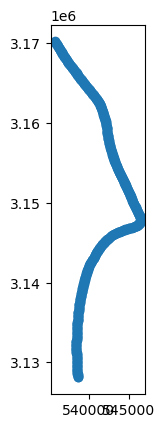

In [8]:
results.plot()
plt.show()

In [9]:
results = prediction_results_to_polygon(results)
output_shapefile = "DSAS_TestData/projection_output.shp"
results.to_file(output_shapefile, driver="ESRI Shapefile")

c:\Users\lalit\anaconda3\envs\environment\lib\site-packages\geopandas\io\file.py:608: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


C:\Users\lalit\AppData\Local\Temp\ipykernel_21672\1391269585.py:1: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  results.plot()


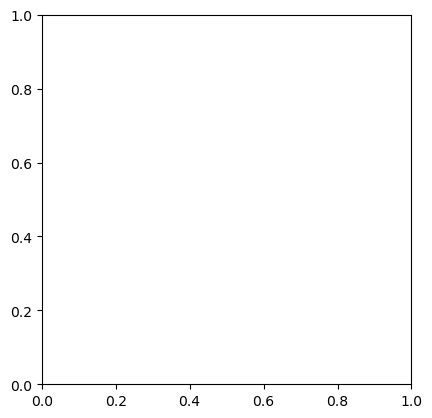

In [10]:
results.plot()
plt.show()